$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \cD {\mathcal{D}}$
$\def \cW {\mathcal{W}}$
$\def \bc {\mathbf{c}}$
$\def \bv {\mathbf{v}}$
$\def \bG {\mathbf{G}}$

# Measurement-driven greedy algorithm

What is unique in this test is that we asses the measurement-driven greedy algorithms against a variety of different solutions $u_h$, and plot the variance of performance of these algorithms in a couple of different ways. 

Note that all the calculations have been offloaded to a heavy weight script: ```scripts/greedy_Vn/07_greedy_Vn_average_cases.py```. Here we simply import the results from this script.
 
We're given our measurement space $W_m = \mathrm{span}\{w_1,\ldots,w_m\}$. We have a series of measurements $\langle w_i, u\rangle_V$, and we write $w := P_{W_m} u$, the projection of $u$ in $W_m$. We do this for a variety of $u$

This algorithm makes a very simple adjustment to the greedy algorithm - it does the argmax search in the $W_m$ projection. Of course as $n \to m$ there is nothing we can do about $\beta(V_n, W_m) \to 0$.

For more information on the greedy algorithms, either see the write up or the earlier notebook ```02_greedy_Vn.ipynb```

In [2]:
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")
import pyhilbert as hil
import pyredmod as rm

%matplotlib inline

results_file = './scripts/results/07_greedy_Vn_stats.npy'
stats = np.load(results_file)
results_file = '../../../01 LJLL/pyApproxTools/scripts/greedy_Vn/results/07_greedy_Vn_stats.npy'
stats_old = np.load(results_file)

/usr/local/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


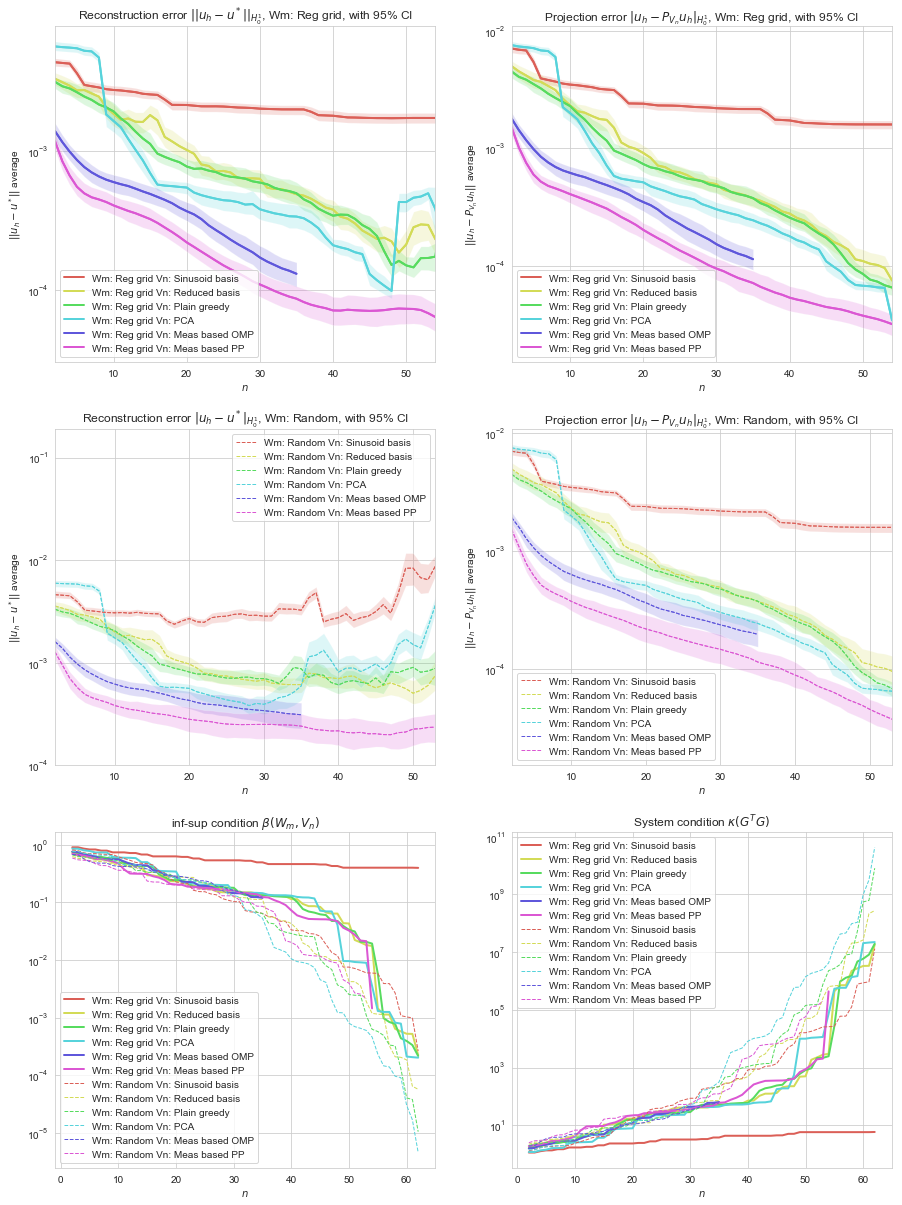

In [3]:
generic_Vns_labels = ['Sinusoid basis', 'Reduced basis', 'Plain greedy', 'PCA']
adapted_Vns_labels = ['Meas based OMP', 'Meas based PP']
Wm_labels = ['Reg grid', 'Random']

sns.set_palette('hls', len(generic_Vns_labels) + len(adapted_Vns_labels))
cp = sns.color_palette()
sns.set_style('whitegrid')

lss = ['-', '--']
lws = [2,1]

axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='Reconstruction error $|| u_h - u^* ||_{H_0^1}$, Wm: Reg grid, with 95% CI'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$, Wm: Reg grid, with 95% CI'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Random, with 95% CI'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$, Wm: Random, with 95% CI'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 5, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 6, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

for i, Wm_label in enumerate(Wm_labels):
    for j, Vn_label in enumerate(generic_Vns_labels):
        
    
        #Vn_n = generic_Vns[j].n
        Vn_n = np.where(np.isclose((~np.isclose(stats[0, i, j, :, :], 0.0)).sum(axis=0), stats.shape[3]))[-1][-1]
        
        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        plt.sca(axs[i*2])
        sns.tsplot(stats[0, i, j, :, 2:Vn_n], range(2, Vn_n), value=Vn_label, ls=lss[i], lw=lws[i], color=cp[j], ci=[100])
        # Below is a duplicate plot just for getting the label in the legend...
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, ls=lss[i], lw=lws[i], color=cp[j])
        plt.ylabel(r'$|| u_h - u^* ||$ average')
        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        sns.tsplot(stats[1, i, j, :, 2:Vn_n], range(2, Vn_n), ls=lss[i], lw=lws[i],color=cp[j], ci=[100])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].mean(axis=0), label=label, ls=lss[i], lw=lws[i], color=cp[j])
        plt.ylabel(r'$|| u_h - P_{V_n} u_h ||$ average')
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)
        
    for j_i, Vn_label in enumerate(adapted_Vns_labels):
        j = j_i + len(generic_Vns_labels)

        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        
        # Some funny biz about n...
        #Vn_ns = [Vn.n for Vn in adapted_Vns[i][j_i]]
        #Vn_n = min(Vn_ns)
        Vn_n = np.where(np.isclose((~np.isclose(stats[0, i, j, :, :], 0.0)).sum(axis=0), stats.shape[3]))[-1][-1]
        
        plt.sca(axs[i*2])
        sns.tsplot(stats[0, i, j, :, 2:Vn_n], range(2, Vn_n), ls=lss[i], lw=lws[i], color=cp[j], ci=[100])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, ls=lss[i], lw=lws[i], color=cp[j])

        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        sns.tsplot(stats[1, i, j, :, 2:Vn_n], range(2, Vn_n), ls=lss[i], lw=lws[i], color=cp[j], ci=[100])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].mean(axis=0), label=label, ls=lss[i], lw=lws[i], color=cp[j])        
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)
        
plt.show()

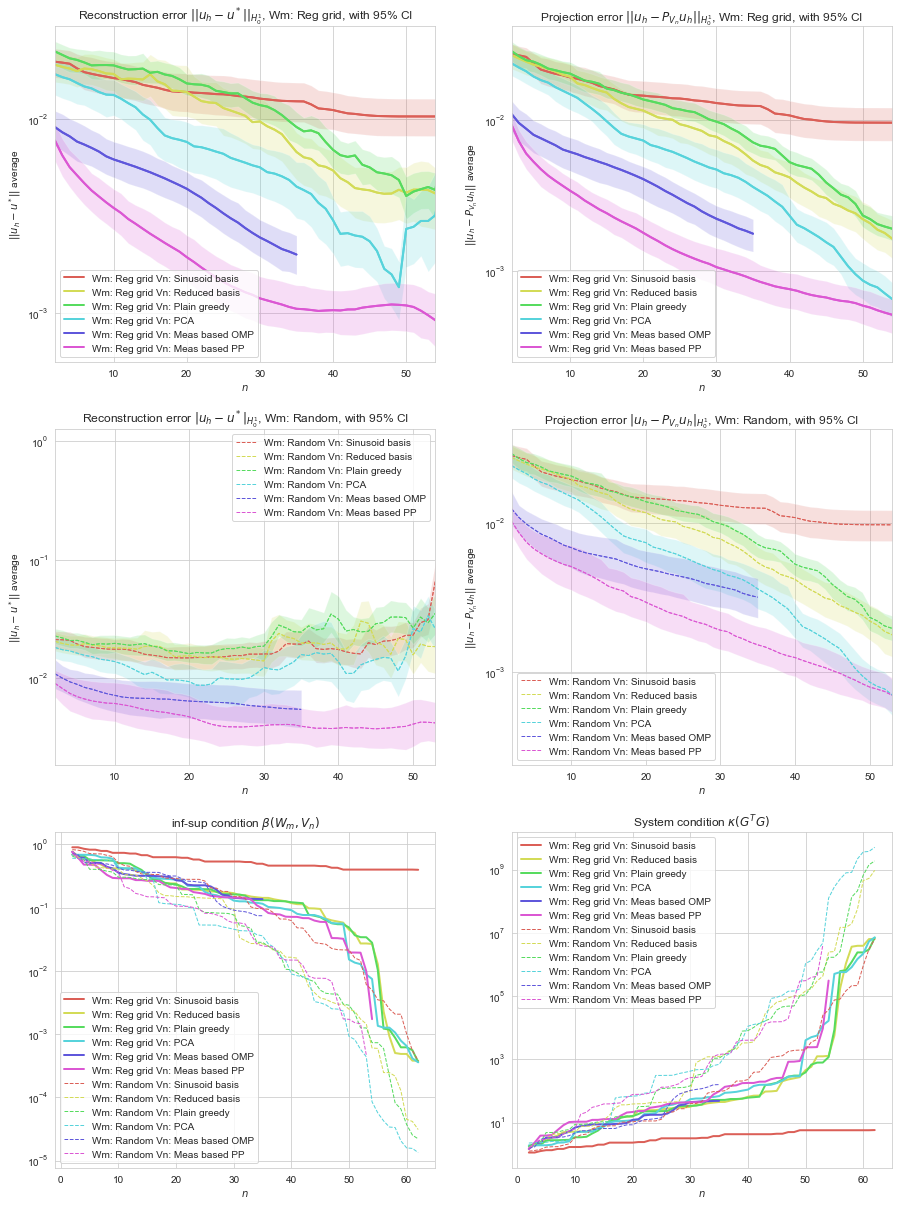

In [4]:
generic_Vns_labels = ['Sinusoid basis', 'Reduced basis', 'Plain greedy', 'PCA']
adapted_Vns_labels = ['Meas based OMP', 'Meas based PP']
Wm_labels = ['Reg grid', 'Random']

sns.set_palette('hls', len(generic_Vns_labels) + len(adapted_Vns_labels))
cp = sns.color_palette()
sns.set_style('whitegrid')

lss = ['-', '--']
lws = [2,1]

axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='Reconstruction error $|| u_h - u^* ||_{H_0^1}$, Wm: Reg grid, with 95% CI'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='Projection error $|| u_h - P_{V_n} u_h ||_{H_0^1}$, Wm: Reg grid, with 95% CI'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Random, with 95% CI'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$, Wm: Random, with 95% CI'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 5, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 6, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

for i, Wm_label in enumerate(Wm_labels):
    for j, Vn_label in enumerate(generic_Vns_labels):
        
    
        #Vn_n = generic_Vns[j].n
        Vn_n = np.where(np.isclose((~np.isclose(stats[0, i, j, :, :], 0.0)).sum(axis=0), stats.shape[3]))[-1][-1]
        
        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        plt.sca(axs[i*2])
        sns.tsplot(stats_old[0, i, j, :, 2:Vn_n], range(2, Vn_n), value=Vn_label, ls=lss[i], lw=lws[i], color=cp[j], ci=[100])
        # Below is a duplicate plot just for getting the label in the legend...
        plt.plot(range(2, Vn_n), stats_old[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, ls=lss[i], lw=lws[i], color=cp[j])
        plt.ylabel(r'$|| u_h - u^* ||$ average')
        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        sns.tsplot(stats_old[1, i, j, :, 2:Vn_n], range(2, Vn_n), ls=lss[i], lw=lws[i],color=cp[j], ci=[100])
        plt.plot(range(2, Vn_n), stats_old[1, i, j, :, 2:Vn_n].mean(axis=0), label=label, ls=lss[i], lw=lws[i], color=cp[j])
        plt.ylabel(r'$|| u_h - P_{V_n} u_h ||$ average')
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats_old[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats_old[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)
        
    for j_i, Vn_label in enumerate(adapted_Vns_labels):
        j = j_i + len(generic_Vns_labels)

        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        
        # Some funny biz about n...
        #Vn_ns = [Vn.n for Vn in adapted_Vns[i][j_i]]
        #Vn_n = min(Vn_ns)
        Vn_n = np.where(np.isclose((~np.isclose(stats[0, i, j, :, :], 0.0)).sum(axis=0), stats.shape[3]))[-1][-1]
        
        plt.sca(axs[i*2])
        sns.tsplot(stats_old[0, i, j, :, 2:Vn_n], range(2, Vn_n), ls=lss[i], lw=lws[i], color=cp[j], ci=[100])
        plt.plot(range(2, Vn_n), stats_old[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, ls=lss[i], lw=lws[i], color=cp[j])

        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        sns.tsplot(stats_old[1, i, j, :, 2:Vn_n], range(2, Vn_n), ls=lss[i], lw=lws[i], color=cp[j], ci=[100])
        plt.plot(range(2, Vn_n), stats_old[1, i, j, :, 2:Vn_n].mean(axis=0), label=label, ls=lss[i], lw=lws[i], color=cp[j])        
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats_old[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats_old[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)
        
plt.show()

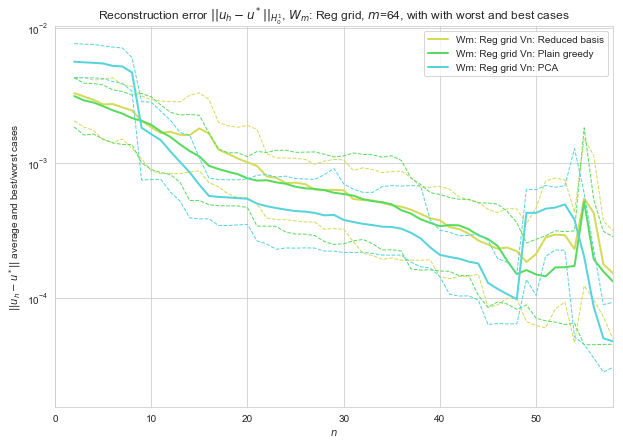

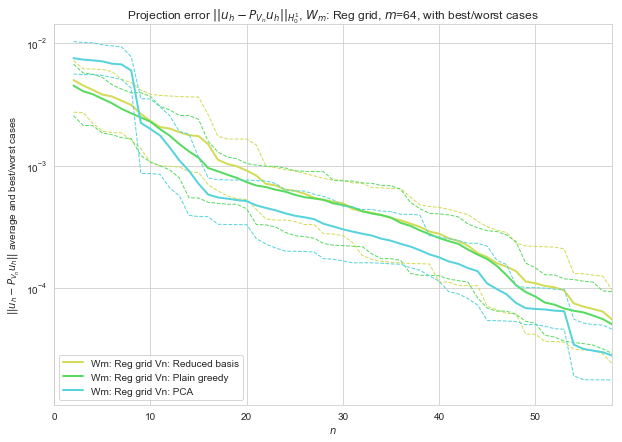

In [9]:
generic_Vns_labels = ['Sinusoid basis', 'Reduced basis', 'Plain greedy', 'PCA']
adapted_Vns_labels = ['Meas based OMP', 'Meas based PP']
Wm_labels = ['Reg grid', 'Random']

sns.set_palette('hls', len(generic_Vns_labels) + len(adapted_Vns_labels))
cp = sns.color_palette()
sns.set_style('whitegrid')

lss = ['-', '--']
lws = [2,1]

i = 0
Wm_label = Wm_labels[i]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1,1,1, title='Reconstruction error $|| u_h - u^* ||_{H_0^1}$, $W_m$: Reg grid, $m$=64, with with worst and best cases')
ax.set(yscale="log", xlabel='$n$')

for j, Vn_label in enumerate(generic_Vns_labels[1:4]):
    j = j+1
    Vn_n = np.where(np.isclose((~np.isclose(stats[0, i, j, :, :], 0.0)).sum(axis=0), stats.shape[3]))[-1][-1]
    label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label


    plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
    plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].max(axis=0), '--', lw=1, color=cp[j])
    plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].min(axis=0), '--', lw=1, color=cp[j])
    
    plt.ylabel(r'$|| u_h - u^* ||$ average and best/worst cases')
    plt.xlim([0,58])
    plt.legend(loc=0)

        
plt.savefig('GreedyReconstructionResultsWC.pdf')
plt.show()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1,1,1, title='Projection error $|| u_h - P_{V_n} u_h ||_{H_0^1}$, $W_m$: Reg grid, $m$=64, with best/worst cases')
ax.set(yscale="log", xlabel='$n$')

for j, Vn_label in enumerate(generic_Vns_labels[1:4]):
    j = j+1
    Vn_n = np.where(np.isclose((~np.isclose(stats[0, i, j, :, :], 0.0)).sum(axis=0), stats.shape[3]))[-1][-1]
    label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label

    
    plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
    plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].max(axis=0), '--', lw=1, color=cp[j])
    plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].min(axis=0), '--', lw=1, color=cp[j])
    plt.ylabel(r'$|| u_h - P_{V_n} u_h ||$ average and best/worst cases')
    plt.xlim([0,58])
    plt.legend(loc=3)

    
plt.savefig('GreedyProjectionResultsWC.pdf')
plt.show()


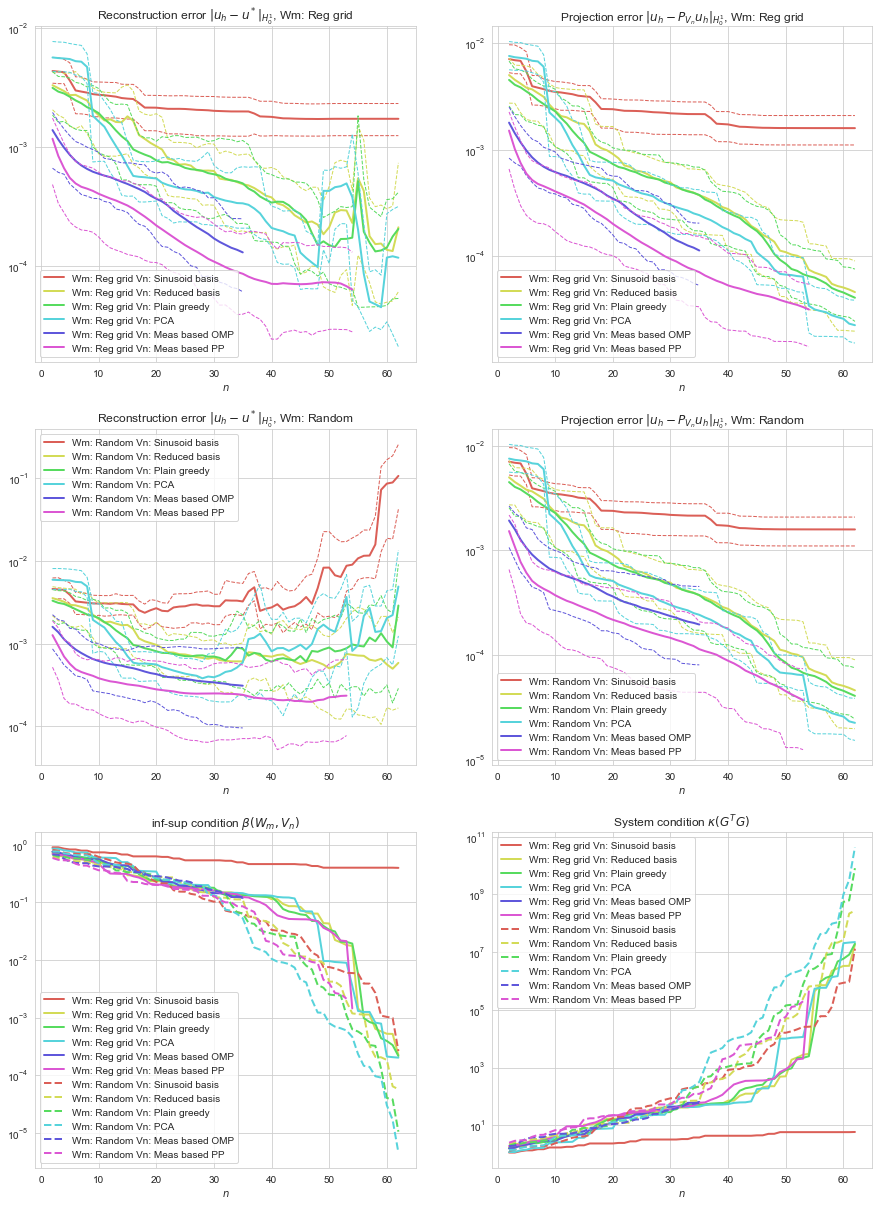

In [10]:
sns.set_palette('hls', len(generic_Vns_labels) + len(adapted_Vns_labels))
cp = sns.color_palette()
sns.set_style('whitegrid')

lss = ['-', '--']
lws = [2,2]

axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Reg grid'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$, Wm: Reg grid'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Random'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$, Wm: Random'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 5, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 6, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

for i, Wm_label in enumerate(['Reg grid', 'Random']):
    for j, Vn_label in enumerate(generic_Vns_labels):
        
        Vn_n = np.where(np.isclose((~np.isclose(stats[0, i, j, :, :], 0.0)).sum(axis=0), stats.shape[3]))[-1][-1]

        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        plt.sca(axs[i*2])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].max(axis=0), '--', lw=1, color=cp[j])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].min(axis=0), '--', lw=1, color=cp[j])
        
        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].max(axis=0), '--', lw=1, color=cp[j])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].min(axis=0), '--', lw=1, color=cp[j])
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)
        
    for j_i, Vn_label in enumerate(adapted_Vns_labels):
        j = j_i + len(generic_Vns_labels)

        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        
        # Some funny biz about n...
        Vn_n = np.where(np.isclose((~np.isclose(stats[0, i, j, :, :], 0.0)).sum(axis=0), stats.shape[3]))[-1][-1]
        
        plt.sca(axs[i*2])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].max(axis=0), '--', lw=1, color=cp[j])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].min(axis=0), '--', lw=1, color=cp[j])
        
        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].max(axis=0), '--', lw=1, color=cp[j])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].min(axis=0), '--', lw=1, color=cp[j])
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)

plt.show()

/usr/local/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


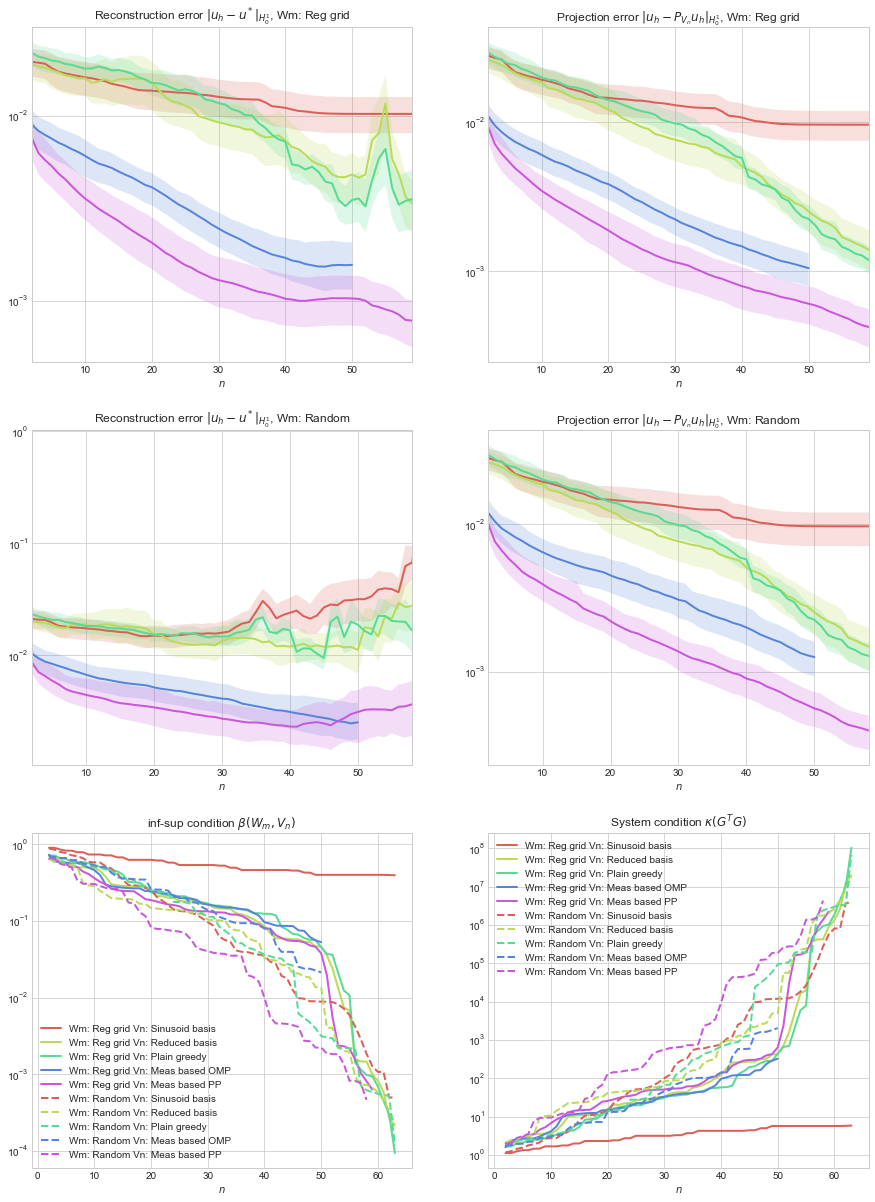

In [29]:
sns.set_palette('hls', len(generic_Vns) + len(adapted_Vns))
cp = sns.color_palette()
sns.set_style('whitegrid')

lss = ['-', '--']
lws = [2,2]

axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Reg grid'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$, Wm: Reg grid'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Random'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$, Wm: Random'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 5, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 6, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

for i, Wm_label in enumerate(['Reg grid', 'Random']):
    for j, Vn_label in enumerate(generic_Vns_labels):
        
        Vn_n = generic_Vns[j].n
        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        plt.sca(axs[i*2])
        sns.tsplot(stats[0, i, j, :, 2:Vn_n], range(2, Vn_n), lw=lws[i], color=cp[j], ci=[100])
        #for k in range(len(us)):
        #    plt.plot(range(2, Vn_n), stats[0, i, j, k, 2:Vn_n], ':', lw=1, color=cp[j])
        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        sns.tsplot(stats[1, i, j, :, 2:Vn_n], range(2, Vn_n),  lw=lws[i],color=cp[j], ci=[100])
        #for k in range(len(us)):
        #    plt.plot(range(2, Vn_n), stats[1, i, j, k, 2:Vn_n], ':', label=label, lw=1, color=cp[j])
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)
        
    for j_i, Vn_label in enumerate(adapted_Vns_labels):
        j = j_i + len(generic_Vns)

        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        
        # Some funny biz about n...
        Vn_ns = [Vn.n for Vn in adapted_Vns[i][j_i]]
        Vn_n = min(Vn_ns)
        
        plt.sca(axs[i*2])
        sns.tsplot(stats[0, i, j, :, 2:Vn_n], range(2, Vn_n), lw=lws[i], color=cp[j], ci=[100])
        #for k in range(len(us)):
        #    plt.plot(range(2, Vn_n), stats[0, i, j, k, 2:Vn_n], ':', label=label, lw=1, color=cp[j])
        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        sns.tsplot(stats[1, i, j, :, 2:Vn_n], range(2, Vn_n), lw=lws[i], color=cp[j], ci=[100])
        #for k in range(len(us)):
        #    plt.plot(range(2, Vn_n), stats[1, i, j, k, 2:Vn_n], ':', label=label, lw=1, color=cp[j])
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)
        
plt.savefig('GreedyMeasSelectionResults.pdf')
plt.show()

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


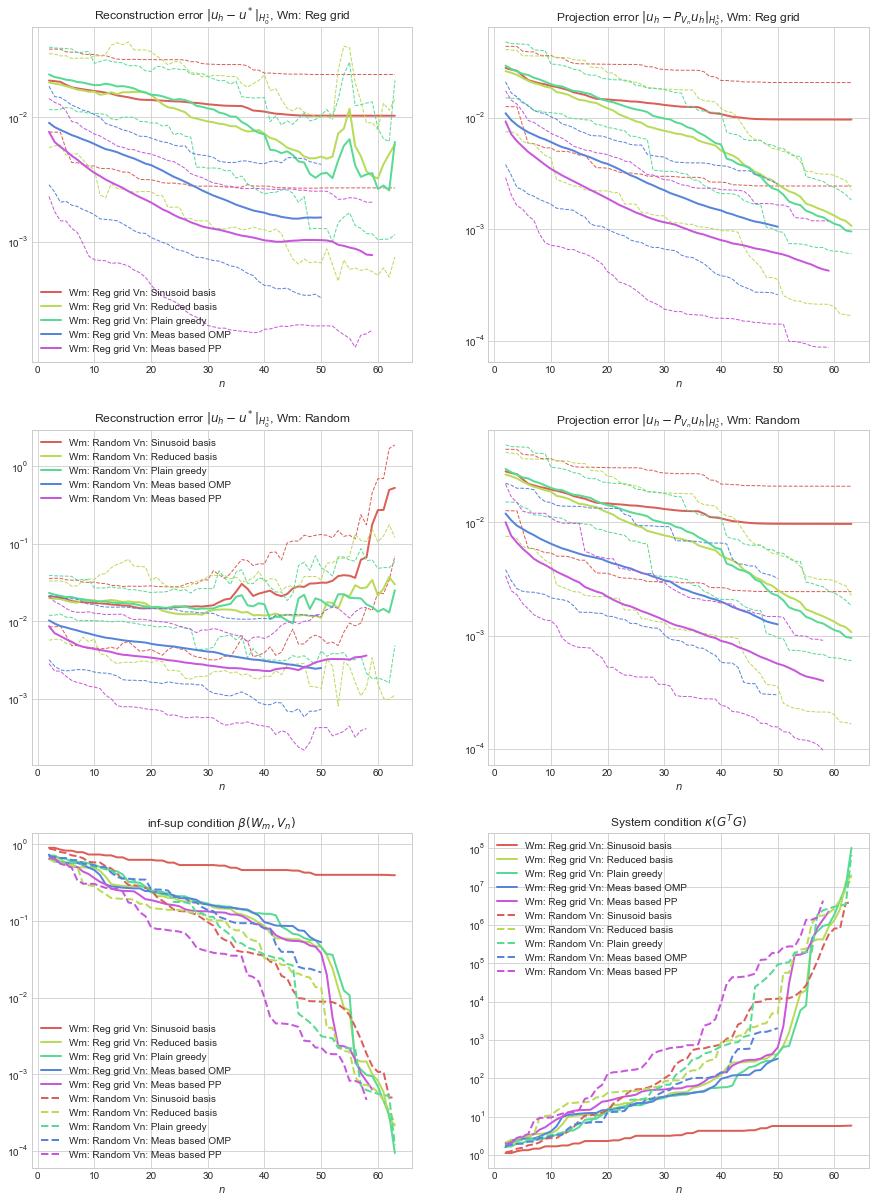

In [31]:
sns.set_palette('hls', len(generic_Vns) + len(adapted_Vns))
cp = sns.color_palette()
sns.set_style('whitegrid')

lss = ['-', '--']
lws = [2,2]

axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Reg grid'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$, Wm: Reg grid'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Random'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title='Projection error $\| u_h - P_{V_n} u_h \|_{H_0^1}$, Wm: Random'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 5, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 6, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

for i, Wm_label in enumerate(['Reg grid', 'Random']):
    for j, Vn_label in enumerate(generic_Vns_labels):
        
        Vn_n = generic_Vns[j].n
        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        plt.sca(axs[i*2])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].max(axis=0), '--', lw=1, color=cp[j])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].min(axis=0), '--', lw=1, color=cp[j])
        
        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].max(axis=0), '--', lw=1, color=cp[j])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].min(axis=0), '--', lw=1, color=cp[j])
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)
        
    for j_i, Vn_label in enumerate(adapted_Vns_labels):
        j = j_i + len(generic_Vns)

        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        
        # Some funny biz about n...
        Vn_ns = [Vn.n for Vn in adapted_Vns[i][j_i]]
        Vn_n = min(Vn_ns)
        
        plt.sca(axs[i*2])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].max(axis=0), '--', lw=1, color=cp[j])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].min(axis=0), '--', lw=1, color=cp[j])
        
        plt.legend(loc=0)
        plt.sca(axs[i*2+1])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].max(axis=0), '--', lw=1, color=cp[j])
        plt.plot(range(2, Vn_n), stats[1, i, j, :, 2:Vn_n].min(axis=0), '--', lw=1, color=cp[j])
        plt.legend(loc=3)
        
        plt.sca(axs[4])
        plt.plot(range(2, Vn_n), stats[2, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=3)
        plt.sca(axs[5])
        plt.plot(range(2, Vn_n), stats[3, i, j, 0, 2:Vn_n], lss[i], label=label, lw=lws[i], color=cp[j])
        plt.legend(loc=2)

        
plt.savefig('GreedyMeasSelectionResults.pdf')
plt.show()

IndexError: list index out of range

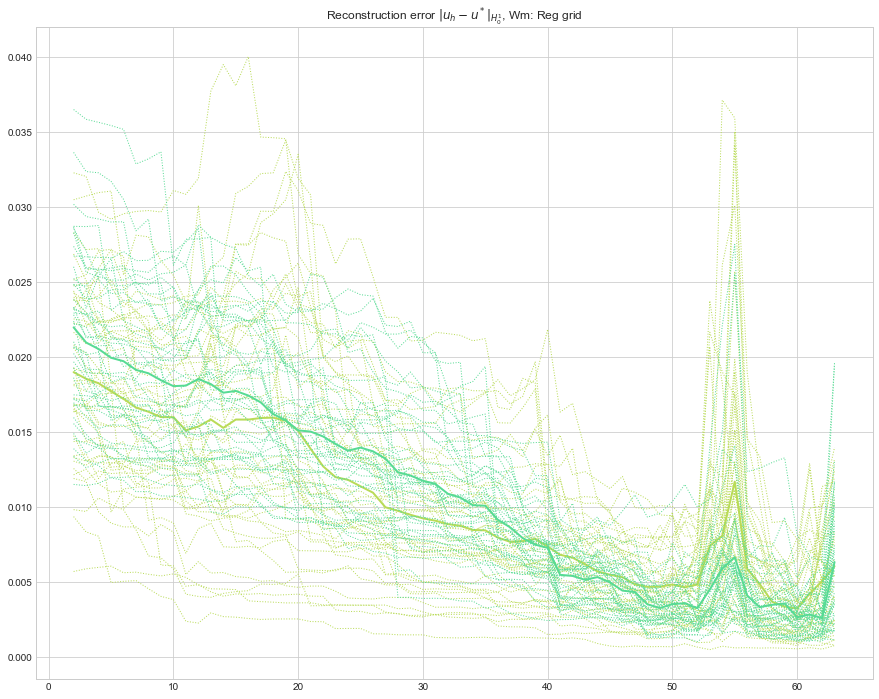

In [34]:
sns.set_palette('hls', len(generic_Vns) + len(adapted_Vns))
cp = sns.color_palette()
sns.set_style('whitegrid')

lss = ['-', '--']
lws = [2,2]

axs = []
fig = plt.figure(figsize=(15, 12))
axs.append(fig.add_subplot(1, 1, 1, title='Reconstruction error $\| u_h - u^* \|_{H_0^1}$, Wm: Reg grid'))

for i, Wm_label in enumerate(['Reg grid', 'Random']):
    for j, Vn_label in enumerate(generic_Vns_labels[1:]):
        j=j+1
        Vn_n = generic_Vns[j].n
        label = 'Wm: ' + Wm_label + ' Vn: ' + Vn_label
        plt.sca(axs[i*2])
        plt.plot(range(2, Vn_n), stats[0, i, j, :, 2:Vn_n].mean(axis=0), label=label, lw=2, color=cp[j])
        for k in range(len(us)):
            plt.plot(range(2, Vn_n), stats[0, i, j, k, 2:Vn_n], ':', lw=1, color=cp[j])        
        
plt.show()